In [1]:
import torch
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from os.path import join
import sys
from tqdm import tqdm

import _init_paths
from data_loader_depth_hg import init_data_loader
from rvmde_mer import network

In [2]:
this_dir = os.path.dirname('.')
dir_data = join(this_dir, '..', 'data')
dir_data

'../data'

In [3]:
def init_env():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")    
    cudnn.benchmark = True if use_cuda else False
    return device

In [4]:
device = init_env()

In [5]:
parser = argparse.ArgumentParser()    
parser.add_argument('--dir_data', type=str)
parser.add_argument('--dir_result', type=str)

parser.add_argument('--test_batch_size', type=int, default=1)
parser.add_argument('--num_workers', type=int, default=0)

parser.add_argument('--d_max', type=float, default=50)
args = parser.parse_args("")
args.dir_data = dir_data
args.path_data_file = join(dir_data, 'prepared_data.h5') 
args.path_radar_file = join(dir_data, 'mer_2_30_5_0.5.h5')
args.dir_result = join(dir_data, 'train_result/depth_completion_hourglass')
args.batch_size = 1

In [6]:
test_loader = init_data_loader(args, 'test')

In [7]:
def load_weights(args, model):
    f_checkpoint = join(args.dir_result, 'checkpoint.tar')        
    print(f_checkpoint)
    if os.path.isfile(f_checkpoint):
        print('load best model')        
        model.load_state_dict(torch.load(f_checkpoint)['state_dict_best'])
    else:
        sys.exit('No model found')
 


In [8]:
f_checkpoint = join(args.dir_result, 'checkpoint.tar')
l = torch.load(f_checkpoint)

In [9]:
model = network(rd_layers = 7).to(device)

load_weights(args, model)       
model.eval()

idx = 30222


../data/train_result/depth_completion_hourglass/checkpoint.tar
load best model


In [10]:
def label2depth_sid(label, K=80.0, alpha=1.0, beta=80, gamma=0.3):
    if torch.cuda.is_available():
        alpha = torch.tensor(alpha)#.cuda()
        beta = torch.tensor(beta)#.cuda()
        K = torch.tensor(K)#.cuda()
    else:
        alpha = torch.tensor(alpha)
        beta = torch.tensor(beta)
        K = torch.tensor(K)

    label = label.float()
    ti_0 = torch.exp(torch.log(alpha) + torch.log(beta/alpha)*label/K) # t(i)
    ti_1 = torch.exp(torch.log(alpha) + torch.log(beta/alpha)*(label+1)/K) # t(i+1)
    depth = (ti_0 + ti_1) / 2 - gamma # avg of t(i) & t(i+1)
    return depth.float()



In [11]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()
    
    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())
    
    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())
    
    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)
    
    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100
    
    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)
    
    mae = np.mean(np.abs(gt - pred))
       
    return silog, log10, mae, abs_rel, sq_rel, rmse, rmse_log, d1, d2, d3

In [24]:
# token = []
# #f = open( "lists-mers/rain.csv", "r" )
# scene = []
# for token in f:
#     scene.append((token).replace("\n", ""))

In [25]:
def evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = False):
    i= 0
    model.eval()
    errors = np.zeros(10)   
    
    with torch.no_grad():
        for sample in tqdm(test_loader, 'Evaluation'):
            #ind = sample['sample_idx'].item()
            #ind = str(ind)
            #if ind in scene:
            i = i+1
            #print(sample['sample_idx'].item())
            #continue
            im, d_radar, gt = sample['im'].to(device), sample['d_radar'].to(device), sample['d_lidar']            
            _pred_prob, _pred_label = model(d_radar, im)
            pred_depth = label2depth_sid(_pred_label)
            prd = ( torch.clamp( pred_depth, min=d_min, max=d_max ) ).to('cpu').numpy()

            if eval_low_height:
                gt = gt * sample['msk_lh']

            gt = gt.numpy()             
            msk_valid = np.logical_and(gt>d_min, gt<d_max)

            errors += compute_errors(gt[msk_valid], prd[msk_valid])           
     
    errors /= i 
       
    print(' \n silog: %f, log10: %f, mae: %f, abs_rel: %f, sq_rel: %f, rmse: %f, rmse_log: %f, d1: %f, d2: %f, d3: %f' \
          % (errors[0], errors[1], errors[2], errors[3], errors[4], errors[5], errors[6], errors[7], errors[8], errors[9]))
   

In [14]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=args.d_max, eval_low_height = True) #Overall evalutation

Evaluation:   0%|                                                                                                                                                                                                                                                | 0/2559 [00:00<?, ?it/s]/home/mlv/miniconda3/envs/nuscenes/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255

 
 silog: 18.407026, log10: 0.056211, mae: 2.567186, abs_rel: 0.141796, sq_rel: 1.036644, rmse: 4.153605, rmse_log: 0.194410, d1: 0.844085, d2: 0.951161, d3: 0.980831


In [15]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = False) #Complete evalutation

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [01:08<00:00, 37.32it/s]

 
 silog: 15.276657, log10: 0.044272, mae: 1.861217, abs_rel: 0.103599, sq_rel: 0.618248, rmse: 3.542967, rmse_log: 0.159944, d1: 0.901160, d2: 0.969913, d3: 0.988183


In [18]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=args.d_max, eval_low_height = True) #DAYS

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:46<00:00, 55.09it/s]

 
 silog: 18.193717, log10: 0.055457, mae: 2.575371, abs_rel: 0.139203, sq_rel: 1.012764, rmse: 4.147185, rmse_log: 0.191418, d1: 0.847865, d2: 0.952379, d3: 0.981268


In [19]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = False) #DAYS

Evaluation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:47<00:00, 53.37it/s]

 
 silog: 14.538576, log10: 0.042068, mae: 1.757716, abs_rel: 0.098240, sq_rel: 0.553904, rmse: 3.393906, rmse_log: 0.151815, d1: 0.910786, d2: 0.973656, d3: 0.989920


In [22]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=args.d_max, eval_low_height = True) #night

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:07<00:00, 328.39it/s]

 
 silog: 21.622850, log10: 0.071894, mae: 3.134582, abs_rel: 0.174293, sq_rel: 1.217659, rmse: 4.752973, rmse_log: 0.230595, d1: 0.754867, d2: 0.932165, d3: 0.977803


In [23]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = False)#night

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:08<00:00, 317.79it/s]

 
 silog: 21.768019, log10: 0.067099, mae: 2.990150, abs_rel: 0.151814, sq_rel: 1.137884, rmse: 5.168583, rmse_log: 0.230720, d1: 0.794015, d2: 0.935268, d3: 0.974259


In [27]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = True)#rain

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:16<00:00, 151.87it/s]

 
 silog: 17.896346, log10: 0.052860, mae: 2.339228, abs_rel: 0.137954, sq_rel: 1.043617, rmse: 3.958129, rmse_log: 0.190444, d1: 0.864683, d2: 0.954304, d3: 0.980604


In [26]:
evaluate(model, test_loader, device, d_min=1e-3, d_max=80, eval_low_height = False)#rain

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2559/2559 [00:17<00:00, 142.54it/s]

 
 silog: 15.170941, log10: 0.042723, mae: 1.768038, abs_rel: 0.102443, sq_rel: 0.625614, rmse: 3.408863, rmse_log: 0.159036, d1: 0.910595, d2: 0.971064, d3: 0.987945


In [39]:
import cv2

In [73]:
def prd_one_sample(model, train_loader, device, idx, args):
    #for i in range(len(frame_array)):
    # writing to a image array

    with torch.no_grad():
        for ct, sample in enumerate(train_loader):
            if ct == idx:
                d_radar1 =  sample['d_radar']
                ix = idx
                im, d_radar, d_lidar = sample['im'].to(device), sample['d_radar'].to(device), sample['d_lidar'].to(device)            
                im, d_radar, gt = sample['im'].to(device), sample['d_radar'].to(device), sample['d_lidar']            
                _pred_prob, _pred_label = model(d_radar, im)
                prd = label2depth_sid(_pred_label)
                #prd = ( torch.clamp( pred_depth, min=d_min, max=d_max ) ).to('cpu').numpy()
            
                im = im[0].permute(1,2,0).to('cpu').numpy()#.astype('uint8')
                d_radar = d_radar[0][0].to('cpu').numpy()
                d_lidar = d_lidar[0][0].to('cpu').numpy()               
                prd = prd[0][0].cpu().numpy()
                
                #break
            
            
    d_max = args.d_max
    d_min = 1e-3
    
    
    prd = prd.clip(d_min, d_max)    
    msk_valid = np.logical_and(d_lidar>d_min, d_lidar<d_max)    
    d_lidar = d_lidar * msk_valid    
    
    d_error = np.abs( d_lidar - prd ) * msk_valid   
    
    depth = np.concatenate([d_lidar, prd], axis = 0)
      
    plt.close('all')   
    
    plt.figure()
    a = plt.imshow(im)
    plt.title('RGB Image')
    plt.axis('off')
    #plt.show()
    plt.savefig(str(idx)+'radar.png',bbox_inches='tight')
    
    plt.figure()
    b  = plt.imshow(d_radar1[0,2:5,:,:].permute(1,2,0))#, cmap='jet')
    plt.title('radar information (MERs)')
    plt.axis('off')
    #plt.colorbar()
    #plt.show()
    plt.savefig(str(idx)+'im.png',bbox_inches='tight')

    
    plt.figure()
    crop_img = depth[190:515, 0:400]
    width = 515
    height = 258
    dim = (width, height)
    dd = cv2.resize(crop_img, dim,interpolation = cv2.INTER_AREA)
    #print(dd.shape)
    
    c = plt.imshow(dd, cmap='jet')
    plt.title('Lidar Based Ground truth')
    plt.axis('off')
    
    #plt.colorbar()
    #plt.show()
    plt.savefig(str(idx)+'lidar.png',bbox_inches='tight')
    
    
    plt.figure()
    plt.imshow(prd, cmap='jet')
    plt.title('Estimated depth')
    #plt.colorbar()
    plt.axis('off')
    plt.savefig(str(idx)+'depth.png',bbox_inches='tight')
    
    #a=cv2.imread(str(idx)+'im.png')
    #b=cv2.imread(str(idx)+'radar.png')
    #img=cv2.imread(str(idx)+'lidar.png')
    #depth=cv2.imread(str(idx)+'depth.png')
    #crop_img = img[190:515, 0:400]
    #width = 515
    #height = 258
    #dim = (width, height)
    #dd = cv2.resize(crop_img, dim,interpolation = cv2.INTER_AREA)
    #print(dd.shape)
#     con = np.concatenate((im,b),axis=0)
#     don = np.concatenate((c, prd),axis=0)
#     c1 = np.concatenate((con, don),axis=1)
#     #return c
#     plt.imshow(c)
    #plt.savefig(str(idx)+'cc.png',bbox_inches='tight')
    #plt.show()
    #a=plt.imread('2494im.png')
    #b=plt.imread('2494radar.png')
    #d = np.concatenate((a,c),axis=0)
    #plt.imshow(d)
    #plt.show()    
    #plt.figure()
    #plt.imshow(d_error, cmap='jet')
    #plt.title('error')
    #plt.colorbar()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


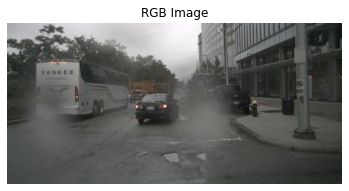

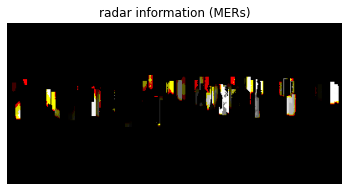

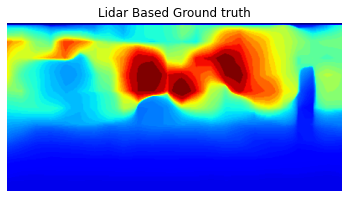

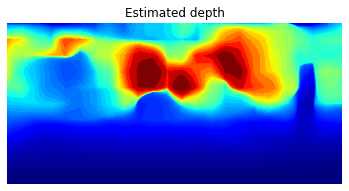

In [94]:
 prd_one_sample(model, test_loader, device, 2012, args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 192, 400]) torch.Size([1, 7, 192, 400]) torch.Size([1, 1, 192, 400])


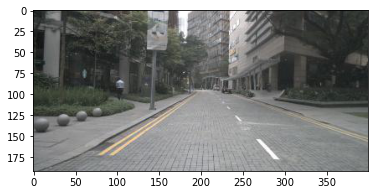

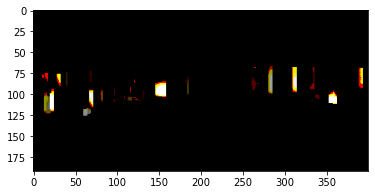

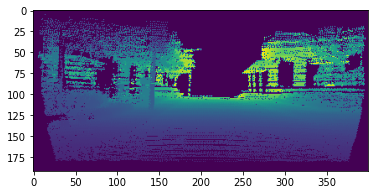

In [38]:
import matplotlib.pylab as plt 
for sample in test_loader:
        _rgb, _sparse_depth, _dense_depth = sample['im'], sample['d_radar'], sample['d_lidar'] 
        #_rgb, _sparse_depth, _dense_depth = data['RGB'], data['SPARSE'], data['DENSE']
        #_rgb, _sparse_depth, _dense_depth = data['RGB'].to(device), data['SPARSE'].to(device), data['DENSE'].to(device)
        #_radar_depth = data['RADAR'].to(device)
        #print(max(_rgb),min(_rgb))
        print(_rgb.shape,_sparse_depth.shape,_dense_depth.shape)
        plt.imshow(_rgb[0,:,:,:].permute(1,2,0))
        plt.figure()
        plt.imshow(_sparse_depth[0,2:5,:,:].permute(1,2,0))
        plt.figure()
        plt.imshow(_dense_depth[0,:,:,:].permute(1,2,0))
        break
plt.show()